<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/gasvaluechain/GasProcessingChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#Install neqsim python package
!pip install neqsim -q

In [2]:
#importing packages used
import pandas as pd
import math
import matplotlib.pyplot as plt

## Gas Processing Calculations using NeqSim
NeqSim is a library for calculation of fluid behavior, phase equilibrium and process simulation. See NeqSim homepage: https://equinor.github.io/neqsimhome/

## Input parameters
The following input parameters are given in the assignment. We will assume that the well stream inlet temperature to platform and rich gas inlet temperature to Kårstø is the same as sea water temperature.

In [3]:
#well stream composition (mole fractions)
reservoirFluid = {'ComponentName':  ['nitrogen', 'CO2', 'methane', 'ethane', 'propane', 'i-butane', 'n-butane', 'i-pentane', 'n-pentane', 'n-hexane','n-heptane', 'n-octane', 'n-nonane', 'nC10'],
        'MolarComposition[-]':  [0.56, 2.02, 81.77, 7.77, 3.91, 0.56, 0.9, 0.25, 0.24, 0.5, 0.3, 0.2, 0.12, 0.91]
}
reservoirFluiddf = pd.DataFrame(reservoirFluid) #create a dataframe of the well fluid
print(reservoirFluiddf.head(20).to_string())

   ComponentName  MolarComposition[-]
0       nitrogen                 0.56
1            CO2                 2.02
2        methane                81.77
3         ethane                 7.77
4        propane                 3.91
5       i-butane                 0.56
6       n-butane                 0.90
7      i-pentane                 0.25
8      n-pentane                 0.24
9       n-hexane                 0.50
10     n-heptane                 0.30
11      n-octane                 0.20
12      n-nonane                 0.12
13          nC10                 0.91


In [4]:
well_head_pressure = 180.0 #bara
well_head_temperature = 80.0 #degC
platform_inlet_pressure = 90.0 #bara
platform_inlet_temperature = 5.0 #C
platform_outlet_pressure = 200.0 #bara
platform_outlet_temperature = 15.0 #C
karsto_inlet_pressure = 110.0 #bara
karsto_inlet_temperature = 5.0 #bara
well_flow_rate = 20.0 #GSm3/year
pipeline_length = 690.0 #km
sea_water_temperature = 5.0 #C
rich_gas_water_dew_point = -10.0 #degC
rich_gas_cricondenbar = 90.0 #bara

# Q1:
Calculate the water dropout during transport from well to platform inlet. Compare the HYSYS calculation with gas solubility diagram given in handouts. Calculate the amount of MEG for hydrate control based on the diagram given in handouts

In [5]:
from neqsim.thermo import fluid_df, printFrame
from neqsim.process import stream,saturator,clearProcess, runProcess, cooler

clearProcess() #reset process simulation

reservoirFluid = fluid_df(reservoirFluiddf, modelName='pr') #create a neqsim fluid from the reservoir fluid dataframe. You can select 'pr', 'srk', or 'cpa-eos'
reservoirFluid.setMixingRule('classic')
reservoirFluid.setMultiPhaseCheck(True) #use multiphase flash in neqsim

wellStream = stream('well stream', reservoirFluid) # create a neqsim stream from the reservoir fluid
wellStream.setTemperature(well_head_temperature, 'C')
wellStream.setPressure(well_head_pressure, 'bara')
wellStream.setFlowRate(well_flow_rate*1000.0/365.0, 'MSm3/day') #convert flow to MSm3/day

#saturate the well stream with water
waterSaturator = saturator('water saturator', wellStream)

#Simulating the pipeline using a cooler
wellFlowLine = cooler('pipeline from well', waterSaturator.getOutStream())
wellFlowLine.setOutTemperature(platform_inlet_temperature, 'C')
wellFlowLine.setOutPressure(platform_inlet_pressure, 'bara')

wellStreamEnteringPlatform = wellFlowLine.getOutStream()

runProcess() #run the process simulation

The MEG injection rate can be calculated using the formula

$wt\%\:MEG = \frac{\dot{m}_{MEG}}{\dot{m}_{MEG} + \dot{m}_{water}}\cdot 100$

For a given wt% MEG, the MEG injection rate can be calculated as

$\dot{m}_{MEG}=\frac{wt\%\:MEG}{100-wt\%\:MEG}\cdot\dot{m}_{water}$

In [6]:
#we will inject MEG to have minimum 45wt% MEG in water entering platform
wtMEG = 45.0

In [7]:
flowRateHydrocarbonGas = wellStream.getFlowRate('MSm3/day')
flowRateSaturatedGas = waterSaturator.getOutStream().getFlowRate('MSm3/day')
waterFromReservoir = waterSaturator.getOutStream().getFluid().getComponent('water').getFlowRate('kg/hr') #read the flow of water from the reservoir
freeWaterEnteringPlatform = wellStreamEnteringPlatform.getFluid().getPhase('aqueous').getComponent('water').getFlowRate('kg/hr') #read the flow of condesed water entering platform
injectionRateMEG = waterFromReservoir*wtMEG/(100.0-wtMEG)
print('total water in gas from reservoir ', waterFromReservoir, ' kg/hr')
print('condensed water entering platform inlet ', freeWaterEnteringPlatform, ' kg/hr')
print('injection rate MEG ', injectionRateMEG, 'kg/hr')

total water in gas from reservoir  5820.2269063420545  kg/hr
condensed water entering platform inlet  5627.300966487732  kg/hr
injection rate MEG  4762.003832461681 kg/hr


# Q2:
Set up and calculate separation and recompression process to meet the process specifications (cricondenbar) in the pipeline. The operational pressure of the inlet separator is set by a platform inlet choke valve. The inlet separation pressure should be selected in order to minimize recompression work. (use sea water for process cooling)

NB!

In the solution proposed below we will use a three stage separation process and and two stage recompression process. The compression ratios of the compressors will be high, and in a real proces we typically wont have a compressor ratio higher than aprox. 3. In a real process we would need more compression stages/coolers  and scrubbers (eg. four stages).

In [8]:
%%capture
inputdata = {
  'firstStagePressure': 69.2,
  'temperatureOilHeater' : 75.0,
  'secondStagePressure': 8.6,
  'thirdStagePressure': 1.3,
  'firstStageSuctionCoolerTemperature': 25.0,
  'secondStageSuctionCoolerTemperature': 25.0,
  'thirdStageSuctionCoolerTemperature':25.0,
  'dewPointScrubberTemperature': 25.0,
  'firstStageExportCoolerTemperature': 25.0,
  'secondStageExportCoolerTemperature': 25.0,
  'compressor_efficiency' : 75.0 #%
}

from neqsim.process import compressor, cooler, separator3phase, getProcess, clearProcess, compsplitter, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle, setpoint, calculator

clearProcess() #reset process simulation

chokeValve = valve('inlet choke', wellFlowLine.getOutStream())
chokeValve.setOutletPressure(inputdata['firstStagePressure'], 'bara')

feedToOffshoreProcess = stream('feed to offshore', chokeValve.getOutStream())
feedToOffshoreProcess.setName("feed to offshore")

firstStageSeparator = separator3phase('1st stage separator', feedToOffshoreProcess)

oilHeaterFromFirstStage = heater('oil heater second stage', firstStageSeparator.getOilOutStream())
oilHeaterFromFirstStage.setOutTemperature(inputdata['temperatureOilHeater'],'C')

oilThrotValve = valve('valve oil from first stage', oilHeaterFromFirstStage.getOutStream())
oilThrotValve.setOutletPressure(inputdata['secondStagePressure'])

secondStageSeparator = separator3phase('2nd stage separator', oilThrotValve.getOutStream())

oilThrotValve2 = valve('valve oil from second stage', secondStageSeparator.getOilOutStream())
oilThrotValve2.setOutletPressure(inputdata['thirdStagePressure'])

thirdStageSeparator = separator3phase('3rd stage separator', oilThrotValve2.getOutStream())

oilThirdStageToSep =  wellStream.clone()
oilThirdStageToSep.setName("resyc oil")
thirdStageSeparator.addStream(oilThirdStageToSep)

stableOil = stream('stable oil', thirdStageSeparator.getOilOutStream())

stableOilPump = pump('oil pump', stableOil,15.0)

firstStageCooler = cooler('1st stage cooler', thirdStageSeparator.getGasOutStream())
firstStageCooler.setOutTemperature(inputdata['firstStageSuctionCoolerTemperature'],'C')

firstStageScrubber = separator("1st stage scrubber", firstStageCooler.getOutStream())

firstStageCompressor = compressor('1st stage compressor', firstStageScrubber.getGasOutStream())
firstStageCompressor.setOutletPressure(inputdata['secondStagePressure'])
firstStageCompressor.setIsentropicEfficiency(inputdata['compressor_efficiency']/100.0)

secondStageMixer = mixer('2nd stage mixer')
secondStageMixer.addStream(firstStageCompressor.getOutStream())
secondStageMixer.addStream(secondStageSeparator.getGasOutStream())

secondStageCooler = cooler("2nd stage cooler", secondStageMixer.getOutStream())
secondStageCooler.setOutTemperature(inputdata['secondStageSuctionCoolerTemperature'],'C')

secondStageScrubber = separator("2nd stage scrubber", secondStageCooler.getOutStream())

secondStageCompressor = compressor("2nd stage compressor", secondStageScrubber.getGasOutStream())
secondStageCompressor.setOutletPressure(inputdata['firstStagePressure'])
secondStageCompressor.setIsentropicEfficiency(inputdata['compressor_efficiency']/100.0)

richGasMixer = mixer("fourth Stage mixer")
richGasMixer.addStream(secondStageCompressor.getOutStream())
richGasMixer.addStream(firstStageSeparator.getGasOutStream())

dewPointControlCooler = cooler("dew point cooler", richGasMixer.getOutStream())
dewPointControlCooler.setOutTemperature(inputdata['dewPointScrubberTemperature'],'C')

dewPointScrubber = separator("dew point scrubber", dewPointControlCooler.getOutStream())

lpLiqmixer = mixer("LP liq gas mixer");
lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

lpResycle = recycle("LP liq resycle")
lpResycle.addStream(lpLiqmixer.getOutStream())
lpResycle.setOutletStream(oilThirdStageToSep)

splitFactors = [1.0]*(dewPointScrubber.getGasOutStream().getFluid().getNumberOfComponents()+1)
splitFactors[-1]=0

watersplitter = compsplitter('TEG dehydration', dewPointScrubber.getGasOutStream(), splitFactors)

dehydratedRichGas = stream('dehydrated rich gas', watersplitter.getSplitStream(0))

runProcess(); #run the process simulation

In [9]:
temperature_firstStageCompressorOut = firstStageCompressor.getOutletStream().getTemperature('C')
compressionratio_firstStageCompressor = firstStageCompressor.getOutletStream().getPressure()/firstStageCompressor.getInletStream().getPressure()

temperature_secondStageCompressorOut = secondStageCompressor.getOutletStream().getTemperature('C')
compressionratio_secondStageCompressor = secondStageCompressor.getOutletStream().getPressure()/secondStageCompressor.getInletStream().getPressure()

In [10]:
TVP = stableOil.TVP(20.0, 'C')
if dewPointScrubber.getGasOutStream().getFluid().hasComponent('water'):
  dewPointScrubber.getGasOutStream().getFluid().removeComponent('water')
  cricondenbar = dewPointScrubber.getGasOutStream().CCB('bara')
offshorecondesateproduction =  stableOilPump.getOutStream().getFlowRate('m3/hr')*24
print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('condensate production [m3/day] ',offshorecondesateproduction)

TVP [bara]  0.993728284493161
cricondenbar [bara]  89.93922338695921
condensate production [m3/day]  9086.374980939356


## Process flow illustration

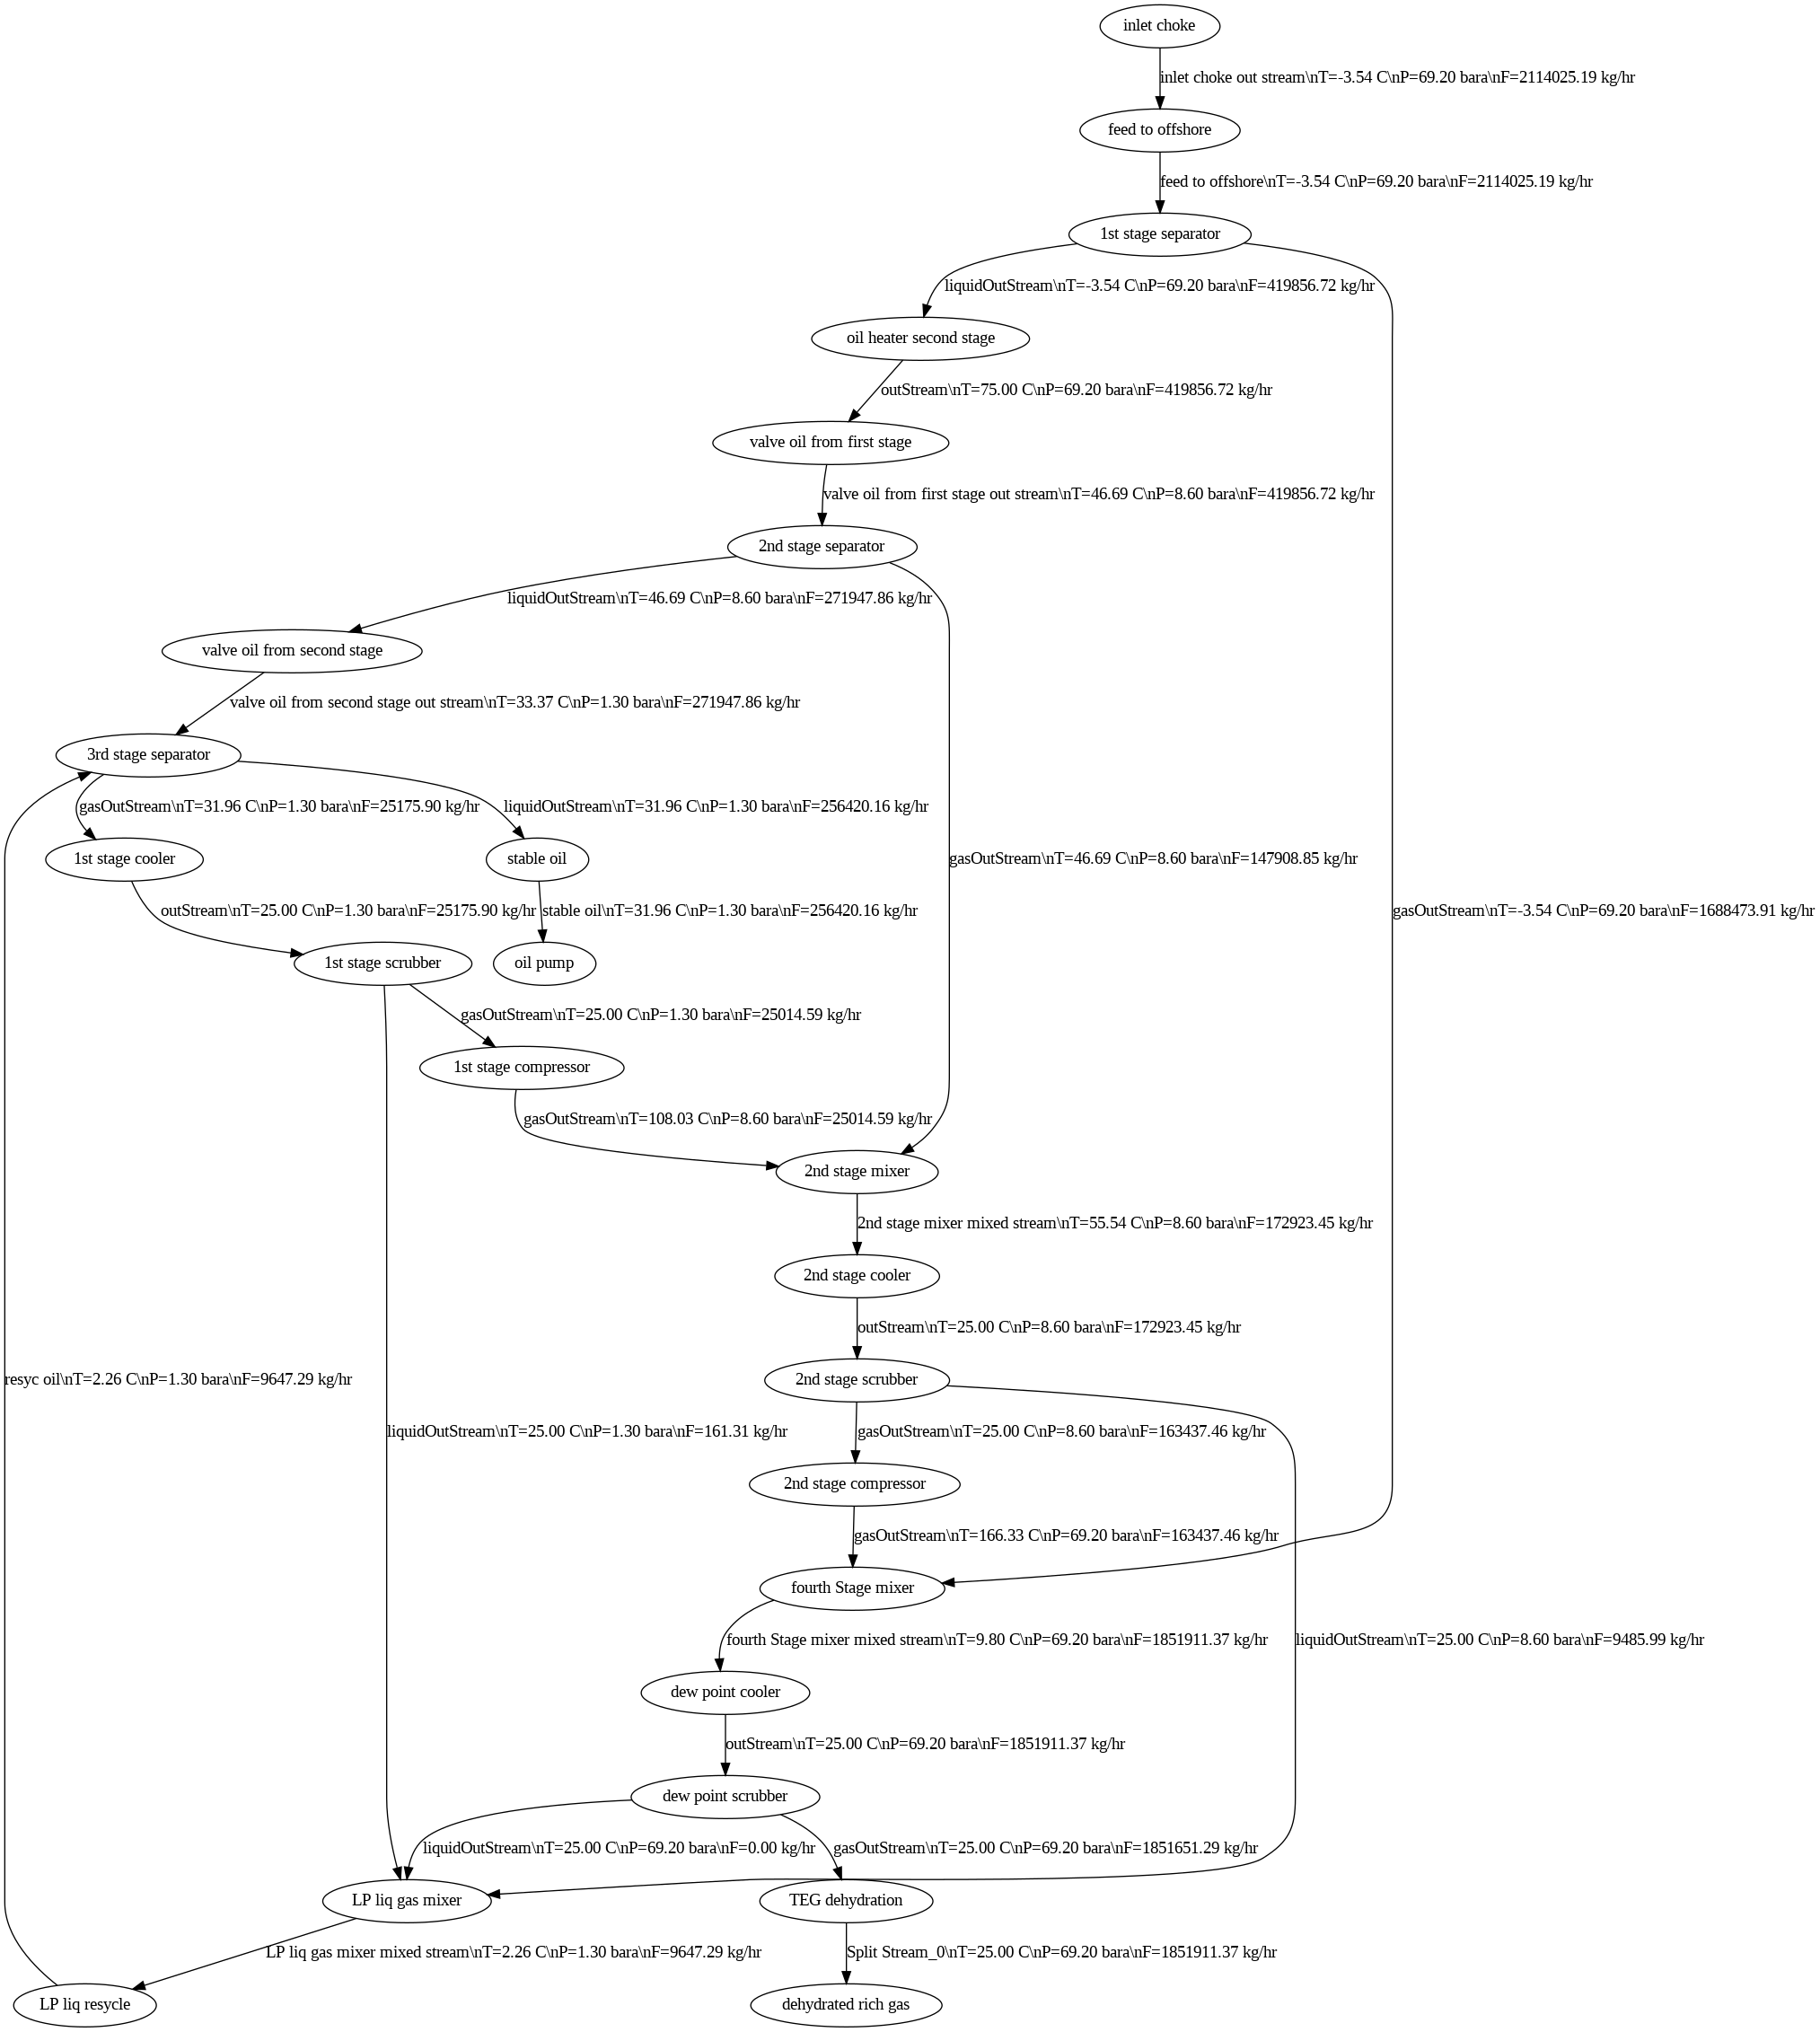

In [11]:
import graphviz
from neqsim import jneqsim as neqsim

options = neqsim.process.processmodel.ProcessSystemGraphvizExporter.GraphvizExportOptions.builder().includeStreamTemperatures(True).includeStreamPressures(True).includeStreamFlowRates(True).includeStreamPropertyTable(False).tablePlacement(
                neqsim.process.processmodel.ProcessSystemGraphvizExporter.GraphvizExportOptions.TablePlacement.BELOW).build()

getProcess().exportToGraphviz("process.dot", options)

# Read the dot file
with open('process.dot', 'r') as f:
    dot_graph = f.read()

# Render the dot file and display it
graphviz.Source(dot_graph).render("process_flow_diagram", format="png", cleanup=True)

from IPython.display import Image
Image('process_flow_diagram.png')

Evaluate two vs. one stage export compressor

In [12]:
#One stage export compression process

clearProcess()

exportCompressor2= compressor("export 2nd stage", dehydratedRichGas)
exportCompressor2.setOutletPressure(platform_outlet_pressure, 'bara')
exportCompressor2.setIsentropicEfficiency(inputdata['compressor_efficiency']/100.0)

exportCooler = cooler("export cooler", exportCompressor2.getOutStream())
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

runProcess()

powerExpComp2 = exportCompressor2.getPower()/1.0e3
print('power export compressor [kW] ', powerExpComp2)
print('discharge temperature ', exportCompressor2.getOutStream().getTemperature('C'), 'C')

power export compressor [kW]  86520.41268710246
discharge temperature  118.7632513629191 C


In [13]:
#Two stage export compression process with intercooling

interstagePressure = math.sqrt(platform_outlet_pressure*dewPointScrubber.getGasOutStream().getPressure('bara'))

clearProcess()

exportCompressor1 = compressor("export 1st stage", dehydratedRichGas)
exportCompressor1.setOutletPressure(interstagePressure, 'bara')
exportCompressor1.setIsentropicEfficiency(inputdata['compressor_efficiency']/100.0)

exportInterstageCooler = cooler("interstage stage cooler", exportCompressor1.getOutStream())
exportInterstageCooler.setOutTemperature(inputdata['firstStageExportCoolerTemperature'],'C')

exportCompressor2= compressor("export 2nd stage", exportInterstageCooler.getOutStream())
exportCompressor2.setOutletPressure(platform_outlet_pressure, 'bara')
exportCompressor2.setIsentropicEfficiency(inputdata['compressor_efficiency']/100.0)

exportCooler = cooler("export cooler", exportCompressor2.getOutStream())
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

exportGas = stream("export gas", exportCooler.getOutStream())

runProcess()

powerExpComp1 = exportCompressor1.getPower()/1.0e3
powerExpComp2 = exportCompressor2.getPower()/1.0e3
print('interstage pressure [bara] ', interstagePressure)
print('power export compressor (total) [kW] ', (powerExpComp1+powerExpComp2))
print('discharge temperature 1', exportCompressor1.getOutStream().getTemperature('C'), 'C', ' discharge temperature 2', exportCompressor2.getOutStream().getTemperature('C'), 'C')

interstage pressure [bara]  117.64352935882194
power export compressor (total) [kW]  76589.84806790354
discharge temperature 1 70.95900554898338 C  discharge temperature 2 66.61520530439049 C


As can be seen the power consumption is reduces siginificantly by selecting a two stage compressor with inter cooling. However a two stage compressor as well as an interstage heat exchanger will be needed.

# Q3
Calculate individual and total compressor work


In [14]:
powerComp1 = firstStageCompressor.getPower()/1.0e3
powerComp2 = secondStageCompressor.getPower()/1.0e3
powerExpComp1 = exportCompressor1.getPower()/1.0e3
powerExpComp2 = exportCompressor2.getPower()/1.0e3
totalCompressorPowerOffshore = (powerComp1+powerComp2+powerExpComp1+powerExpComp2)
print('first stage recompressor power [kW] ', powerComp1)
print('second stage recompressor power [kW] ', powerComp2)
print('first stage export compressor power [kW] ', powerExpComp1)
print('second stage export compressor power [kW] ', powerExpComp2)
print('total power for offshore compressors [kW] ', totalCompressorPowerOffshore)

first stage recompressor power [kW]  993.5323240634063
second stage recompressor power [kW]  11093.273540240725
first stage export compressor power [kW]  39602.538916681304
second stage export compressor power [kW]  36987.309151222245
total power for offshore compressors [kW]  88676.65393220767


#Q4
Estimate heat transfer area of all compressor after-coolers (assume an U value of 1000 W/m^2K for designing the after-coolers). We assume that cooling is done by sea water, and that the inlet cooling water temperature is 5$^{\circ}$C and that the outlet water temperature is 20$^{\circ}$. Heating is provided with a heating medium with an inlet temperature of 120$^{\circ}$ and an outlet temperature of 60$^{\circ}$.

We assume counter current flow in the heat exchangers, and use the following equation for finding nessesary the heat exchanger area.

$Q=U\cdot A\cdot LMTD$

Where Q is the duty of the heat exhanger and the logarithmic mean temperature difference is calcuated from

$LMTD=\frac{\Delta T_{hot} - \Delta T_{cold}}{\frac{\Delta T_{hot}}{\Delta T_{cold}}}$

In [15]:
#Assumptions
U_heatExchanger = 1000.0 # W/(m^2K)
coolingwater_inlet_temperature = 5.0 #degC
coolingwater_outlet_temperature = 20.0 #degC

heating_medium_inlet_temperature = 120.0 #degC
heating_medium_outlet_temperature = 60.0 #degC

In [16]:
exportInterstageCoolerDuty = exportInterstageCooler.getDuty()/1.0e3
exportCoolerDuty = exportCooler.getDuty()/1.0e3
gasHeaterDuty = dewPointControlCooler.getDuty()/1.0e3
firstStageCoolerDuty = firstStageCooler.getDuty()/1e3
secondStageCoolerDuty = secondStageCooler.getDuty()/1e3
oilHeaterDuty = oilHeaterFromFirstStage.getDuty()/1e3
print('first stage cooler duty [kW] ', firstStageCoolerDuty)
print('second stage cooler duty [kW] ', secondStageCoolerDuty)
print('gas heater duty [kW] ', gasHeaterDuty)
print('export interstage compressor after cooler [kW] ', exportInterstageCoolerDuty)
print('export compressor after cooler [kW] ', exportCoolerDuty)
print('oil heater duty [kW] ', oilHeaterDuty)

first stage cooler duty [kW]  -99.7417875792693
second stage cooler duty [kW]  -3722.552009216279
gas heater duty [kW]  21772.33153069676
export interstage compressor after cooler [kW]  -71456.1232765973
export compressor after cooler [kW]  -70452.1866279742
oil heater duty [kW]  25220.718484834175


In [17]:
#Calculate first stage cooler area
deltaTA = firstStageCooler.getInStream().getTemperature('C')-coolingwater_outlet_temperature
deltaTB = firstStageCooler.getOutStream().getTemperature('C')-coolingwater_inlet_temperature
LMTD = (deltaTA-deltaTB)/(math.log(deltaTA/deltaTB))
A = -firstStageCoolerDuty*1e3/U_heatExchanger/LMTD
print('gas flow [kg/hr] ', firstStageCooler.getInStream().getFlowRate('kg/hr'),' gas in temperature ', firstStageCooler.getInStream().getTemperature('C'), ' out temperature ', firstStageCooler.getOutStream().getTemperature('C'))
print("first stage cooler area ", round(A,3), " m^2")

gas flow [kg/hr]  25175.896647786933  gas in temperature  31.955162950033582  out temperature  25.0
first stage cooler area  6.38  m^2


In [18]:
#Calculate second stage recompressor cooler are
deltaTA = secondStageCooler.getInStream().getTemperature('C')-coolingwater_outlet_temperature
deltaTB = secondStageCooler.getOutStream().getTemperature('C')-coolingwater_inlet_temperature
LMTD = (deltaTA-deltaTB)/(math.log(deltaTA/deltaTB))
A = -secondStageCoolerDuty*1e3/U_heatExchanger/LMTD
print('gas flow [kg/hr] ', secondStageCooler.getInStream().getFlowRate('kg/hr'),' gas in temperature ', secondStageCooler.getInStream().getTemperature('C'), ' out temperature ', secondStageCooler.getOutStream().getTemperature('C'))
print("second stage recompressor cooler area ", round(A,3), " m^2")

gas flow [kg/hr]  172923.445526978  gas in temperature  55.53986125252362  out temperature  25.0
second stage recompressor cooler area  137.722  m^2


In [19]:
#Calculate interstage export compressor cooler area
deltaTA = exportInterstageCooler.getInStream().getTemperature('C')-coolingwater_outlet_temperature
deltaTB = exportInterstageCooler.getOutStream().getTemperature('C')-coolingwater_inlet_temperature
LMTD = (deltaTA-deltaTB)/(math.log(deltaTA/deltaTB))
A = -exportInterstageCoolerDuty*1e3/U_heatExchanger/LMTD
print('gas flow [kg/hr] ', exportInterstageCooler.getInStream().getFlowRate('kg/hr'),' gas in temperature ', exportInterstageCooler.getInStream().getTemperature('C'), ' out temperature ', exportInterstageCooler.getOutStream().getTemperature('C'))
print("interstage export compressor cooler area ", round(A,3), " m^2")

gas flow [kg/hr]  1851911.3707393329  gas in temperature  70.95900554898338  out temperature  25.0
interstage export compressor cooler area  2158.73  m^2


In [20]:
#Calculate export compressor cooler area
deltaTA = exportCooler.getInStream().getTemperature('C')-coolingwater_outlet_temperature
deltaTB = exportCooler.getOutStream().getTemperature('C')-coolingwater_inlet_temperature
LMTD = (deltaTA-deltaTB)/math.log(deltaTA/deltaTB)
A = -exportCoolerDuty*1e3/U_heatExchanger/LMTD
print('gas flow [kg/hr] ', exportCooler.getInStream().getFlowRate('kg/hr'),' gas in temperature ', exportCooler.getInStream().getTemperature('C'), ' out temperature ', exportCooler.getOutStream().getTemperature('C'))
print("export compressor cooler area ", round(A,3), " m^2")

gas flow [kg/hr]  1851911.3707393329  gas in temperature  66.61520530439049  out temperature  25.0
export compressor cooler area  2239.932  m^2


### Heat transfer area for gas and oil heaters
Calculation of heaters was not asked for, but area for the heaters could be calculated in the same way as compressor after coolers.

In [21]:
#Calculate rich gas heater area
deltaTA = richGasMixer.getOutStream().getTemperature('C')-heating_medium_outlet_temperature
deltaTB = dewPointControlCooler.getOutStream().getTemperature('C')-heating_medium_inlet_temperature
LMTD = (deltaTA-deltaTB)/(math.log(deltaTA/deltaTB))
A = -gasHeaterDuty*1e3/U_heatExchanger/LMTD
print('gas flow [kg/hr] ', dewPointControlCooler.getInStream().getFlowRate('kg/hr'),' gas in temperature ', dewPointControlCooler.getInStream().getTemperature('C'), ' out temperature ', dewPointControlCooler.getOutStream().getTemperature('C'))
print("rich gas heater area area ", round(A,3), " m^2")

gas flow [kg/hr]  1851911.3707393329  gas in temperature  9.79849428386865  out temperature  25.0
rich gas heater area area  309.99  m^2


In [22]:
#Calculate oil heater area
deltaTA = oilHeaterFromFirstStage.getInStream().getTemperature('C')-heating_medium_outlet_temperature
deltaTB = oilHeaterFromFirstStage.getOutStream().getTemperature('C')-heating_medium_inlet_temperature
LMTD = (deltaTA-deltaTB)/math.log(deltaTA/deltaTB)
A = -oilHeaterDuty*1e3/U_heatExchanger/LMTD
print('oil flow [kg/hr] ', oilHeaterFromFirstStage.getInStream().getFlowRate('kg/hr'),' oil in temperature ', oilHeaterFromFirstStage.getInStream().getTemperature('C'), ' out temperature ', oilHeaterFromFirstStage.getOutStream().getTemperature('C'))
print("oil heater area ", round(A,3), " m^2")

oil flow [kg/hr]  419856.7155061662  oil in temperature  -3.5441198297371557  out temperature  75.0
oil heater area  469.311  m^2


# Q5
Estimate internal diameters of all gas scrubbers

In [23]:
gas_load_factor = 0.1

In the dew oint scrubber there will be no liquids at normal operation. We therefore assume a liquid density of 600 kg/m3 for the scrubber design (oil density).

In [24]:
#Dew point scrubber
flowRate = dewPointScrubber.getGasOutStream().getFlowRate("m3/sec")
gas_density = dewPointScrubber.getGasOutStream().getFluid().getPhase("gas").getDensity("kg/m3")
liquid_density = 600.0

V_t = gas_load_factor*math.sqrt((liquid_density-gas_density)/gas_density)

A_scrub = flowRate/V_t

D_scrub = math.sqrt(A_scrub/(3.14/4.0))

print("gas density ", round(gas_density,3), " [kg/m3)]")
print("Liquid density ", round(liquid_density,3), " [kg/m3]")
print("Maximum gas velocity ", round(V_t,3), " [m/sec]")
print("Minimum scrubber internal diameter ", round(D_scrub,3), " [m]")

gas density  67.339  [kg/m3)]
Liquid density  600.0  [kg/m3]
Maximum gas velocity  0.281  [m/sec]
Minimum scrubber internal diameter  5.882  [m]


In [25]:
#First stage scrubber
flowRate = firstStageScrubber.getGasOutStream().getFlowRate("m3/sec")
gas_density = firstStageScrubber.getGasOutStream().getFluid().getPhase("gas").getDensity("kg/m3")
liquid_density = firstStageScrubber.getLiquidOutStream().getFluid().getDensity("kg/m3")

V_t = gas_load_factor*math.sqrt((liquid_density-gas_density)/gas_density)

A_scrub = flowRate/V_t

D_scrub = math.sqrt(A_scrub/(3.14/4.0))

print("gas density ", round(gas_density,3), " [kg/m3)]")
print("liquid density ", round(liquid_density,3), " [kg/m3]")
print("Maximum gas velocity ", round(V_t,3), " [m/sec]")
print("Minimum scrubber internal diameter ", round(D_scrub,3), " [m]")

gas density  2.468  [kg/m3)]
liquid density  665.64  [kg/m3]
Maximum gas velocity  1.639  [m/sec]
Minimum scrubber internal diameter  1.479  [m]


In [26]:
#Second stage scrubber
flowRate = secondStageScrubber.getGasOutStream().getFlowRate("m3/sec")
gas_density = secondStageScrubber.getGasOutStream().getFluid().getPhase("gas").getDensity("kg/m3")
liquid_density = secondStageScrubber.getLiquidOutStream().getFluid().getDensity("kg/m3")

V_t = gas_load_factor*math.sqrt((liquid_density-gas_density)/gas_density)

A_scrub = flowRate/V_t

D_scrub = math.sqrt(A_scrub/(3.14/4.0))

print("gas density ", round(gas_density,3), " [kg/m3)]")
print("liquid density ", round(liquid_density,3), " [kg/m3]")
print("Maximum gas velocity ", round(V_t,3), " [m/sec]")
print("Minimum scrubber internal diameter ", round(D_scrub,3), " [m]")

gas density  11.043  [kg/m3)]
liquid density  599.449  [kg/m3]
Maximum gas velocity  0.73  [m/sec]
Minimum scrubber internal diameter  2.679  [m]


# Q6
Calculate necessary TEG purity based on an outlet temperature of 25 °C from the absorber

A water dew point of -10 C means we need to have a lean TEG quality of at least 97.0 wt%

#Q7
Estimate the internal diameter of the transport line from platform to the Kårstø onshore process in order to obtain the specified pressure drop.


In [27]:
from neqsim.process import pipeline

#Creating stream and pipeline
clearProcess()

diameter = [0.965, 0.965, 0.965, 0.965, 0.965] #meter
roughnes = [50.0e-6, 50.0e-6, 50.0e-6, 50.0e-6, 50.0e-6] #meter
position = [0.0, 5000.0, 100000.0, 600000.0, 700000.0] #meter
height = [0.0, -200.0, -300.0, -250.0, 0.0] #meter
outtemperatures =[278.15, 278.15, 278.15, 278.15, 278.15] #Kelvin
outHeatU = [25.0, 25.0, 25.0, 25.0, 25.0] #W/m2K
wallHeatU = [35.0, 35.0, 35.0, 35.0, 35.0] #W/m2K

pipe1 = pipeline('pipeline', exportGas, position, diameter, height, outtemperatures, roughnes,outHeatU,wallHeatU)
pipe1.setNumberOfNodesInLeg(100)
runProcess()
numberofnodes = pipe1.getPipe().getTotalNumberOfNodes()
print('outlet pressure ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getPressure('bara'))
print('outlet temperature ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getTemperature('C'))

outlet pressure  96.29320112597935
outlet temperature  -2.3729694198237326


total linepack  100.53428378933617  million tonnes gas
transport time gas  54.342876486637685  hrs


Text(0.5, 0, 'position [meter]')

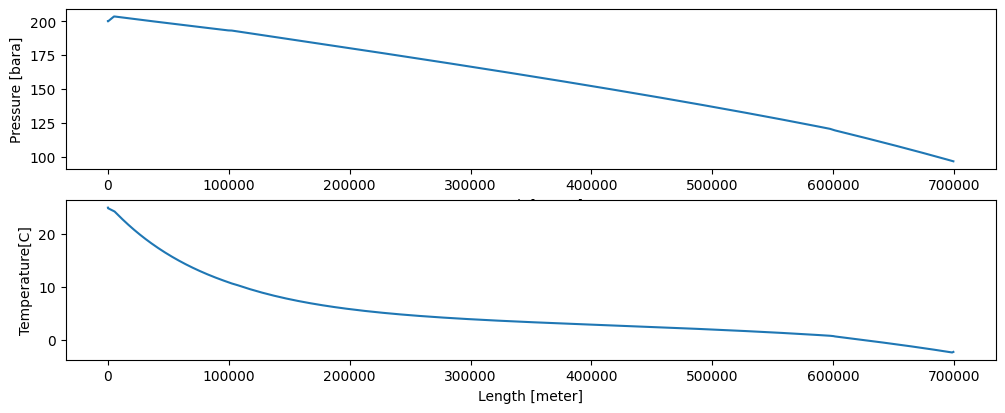

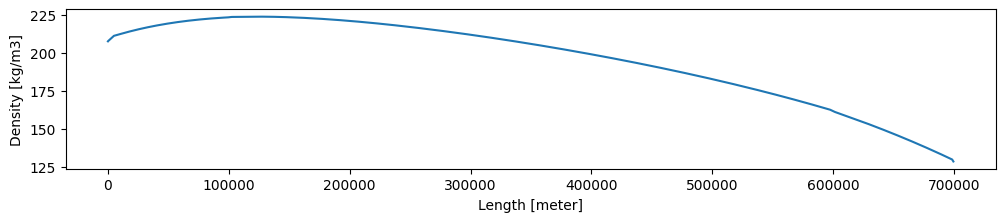

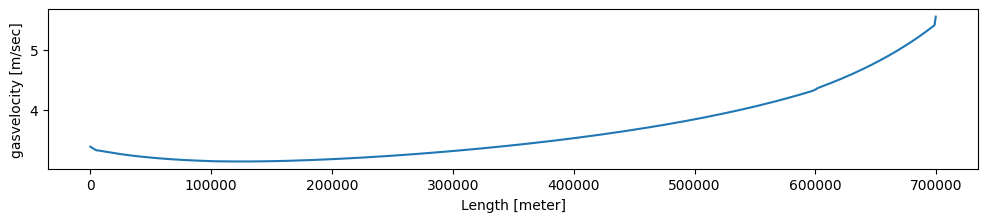

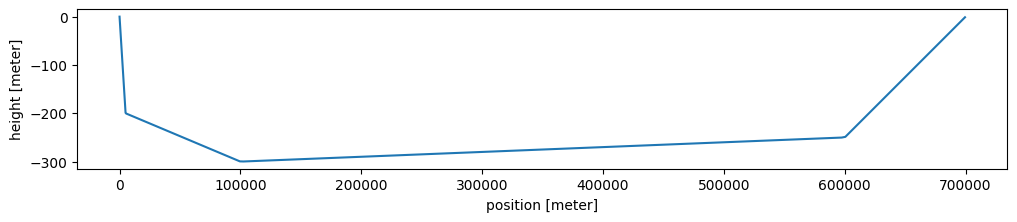

In [28]:
pres = []
temp = []
length = []
height = []
calcdensity = []
gasvelocity = []
linepack = 0
transportTimeGas = 0

for node in range (0, pipe1.getPipe().getTotalNumberOfNodes()-1):
  pres.append(pipe1.getPipe().getNode(node).getBulkSystem().getPressure('bara'))
  temp.append(pipe1.getPipe().getNode(node).getBulkSystem().getTemperature('C'))
  height.append(pipe1.getPipe().getNode(node).getVerticalPositionOfNode())
  length.append(pipe1.getPipe().getNode(node).getDistanceToCenterOfNode())
  calcdensity.append(pipe1.getPipe().getNode(node).getBulkSystem().getDensity('kg/m3'))
  gasvelocity.append(pipe1.getPipe().getNode(node).getVelocity())
  linepack += pipe1.getPipe().getNode(node+1).getBulkSystem().getDensity("kg/m3")*pipe1.getPipe().getNode(node+1).getLengthOfNode()*pipe1.getPipe().getNode(node+1).getGeometry().getArea()
  transportTimeGas += pipe1.getPipe().getNode(node).getLengthOfNode()/pipe1.getPipe().getNode(node).getVelocity()

print('total linepack ', linepack/1.0e6, ' million tonnes gas')
print('transport time gas ', transportTimeGas/3600, ' hrs')
plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.subplot(5, 1, 1)
plt.plot(length, pres, '-')
plt.ylabel('Pressure [bara]')
plt.xlabel('Length [meter]')

plt.subplot(5, 1, 2)
plt.plot(length, temp)
plt.xlabel('Length [meter]')
plt.ylabel('Temperature[C]')

plt.figure()
plt.subplot(5, 1, 3)
plt.plot(length, calcdensity, '-')
plt.ylabel('Density [kg/m3]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(5, 1, 4)
plt.plot(length, gasvelocity, '-')
plt.ylabel('gasvelocity [m/sec]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(5, 1, 5)
plt.plot(length, height, '-')
plt.ylabel('height [meter]')
plt.xlabel('position [meter]')

# Q8
Set up and calculate a simple expander extraction process at Kårstø in order to obtain a propane content less than 1.0 mole % in the dry gas (neglect further processing of the liquid product). We assume an UA of the cross heat exchanger of 3000 kW/K ( eg U=1000 W/m2K and heat transfer area of 3000 m2).

In [44]:
#NGL expander code
from neqsim.process import expander, heater, compsplitter, separator, heatExchanger

pressureNGL = 47.0

clearProcess()

inletheater = heater('inlet heater', pipe1.getOutStream())
inletheater.setOutPressure(karsto_inlet_pressure, 'bara')
inletheater.setOutTemperature(karsto_inlet_temperature, 'C')

inletValve = valve('inlet valve', inletheater.getOutStream())
inletValve.setPressure(karsto_inlet_pressure, 'bara')

heatEx = heatExchanger('hx1', inletValve.getOutStream())
heatEx.setName("cross heat-exchanger")
heatEx.setGuessOutTemperature(273.15 - 30.0)
heatEx.setUAvalue(3000e3) #assumes an UA vlue of 3000 MW/m2K

expanderKarsto = expander('onshore expander', heatEx.getOutStream(0), pressureNGL)
expanderKarsto.setOutletPressure(pressureNGL)
expanderKarsto.setIsentropicEfficiency(inputdata['compressor_efficiency']/100.0) # assume same efficiency as for compressors

scrubberNGL = separator('scurbber', expanderKarsto.getOutletStream())

recyOut = stream('rec stream', scrubberNGL.getGasOutStream().clone())

gasResycle = recycle("gas resycle")
gasResycle.addStream(scrubberNGL.getGasOutStream())
gasResycle.setOutletStream(recyOut)

heatEx.setFeedStream(1, recyOut)

dryGasExportCompressor = compressor('exp compressor', heatEx.getOutStream(1))
dryGasExportCompressor.setOutletPressure(200.0, 'bara')
dryGasExportCompressor.setIsentropicEfficiency(0.75)

exportDryGas = stream('sales gas', dryGasExportCompressor.getOutStream())

runProcess()

In [46]:
nglproduction = scrubberNGL.getLiquidOutStream().getFlowRate('kg/hr')*24/1000.0
print('NGL production [tons/day] ' , nglproduction)
print('propane in dry export gas ', exportDryGas.getFluid().getComponent('propane').getx()*100.0, ' mol%')
print('temperature in NGL scrubber ', expanderKarsto.getOutStream().getTemperature('C'))

printFrame(exportDryGas.getFluid())

NGL production [tons/day]  13321.886462266486
propane in dry export gas  1.0203696505833695  mol%
temperature in NGL scrubber  -56.12543086393367
| 0                    | 1          | 2                  | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:-------------------|:----|:----|:----|:----------------|
|                      | total      | GAS                |     |     |     |                 |
| nitrogen             | 6.9414E-3  | 6.9414E-3          |     |     |     | [mole fraction] |
| CO2                  | 1.80009E-2 | 1.80009E-2         |     |     |     | [mole fraction] |
| methane              | 9.14715E-1 | 9.14715E-1         |     |     |     | [mole fraction] |
| ethane               | 4.8769E-2  | 4.8769E-2          |     |     |     | [mole fraction] |
| propane              | 1.02037E-2 | 1.02037E-2         |     |     |     | [mole fraction] |
| i-butane             | 6.28729E-4 | 6.28729E-4         |     |     |     | [mole fraction] |

# Q9
Find the water dew point specifications necessary of the onshore dehydration unit based on the operational conditions of the expander process.

In [47]:
waterDewPointTemperature = scrubberNGL.getGasOutStream().getTemperature('C')
print('water dew point temperauter NGL ', waterDewPointTemperature, ' degC')

water dew point temperauter NGL  -56.12543086393367  degC


# Q10
Calculate necessary compressor work to meet export pressure.

In [48]:
powerProduced = expanderKarsto.getPower()/1.0e3
powerExpCompressor = dryGasExportCompressor.getPower()/1.0e3
totalPowerOnshore = powerExpCompressor+powerProduced
print('expander produced power [kW] ', powerProduced)
print('dry gas export compressor power [kW] ', powerExpCompressor)
print('net power consumption [kW] ', totalPowerOnshore)

expander produced power [kW]  -16213.238222480417
dry gas export compressor power [kW]  96085.7163253141
net power consumption [kW]  79872.47810283369


#Q11
Calculate and plot phase diagram for reservoir gas, export gas from platform (rich gas) and sales gas from Kårstø

##Reservoir fluid

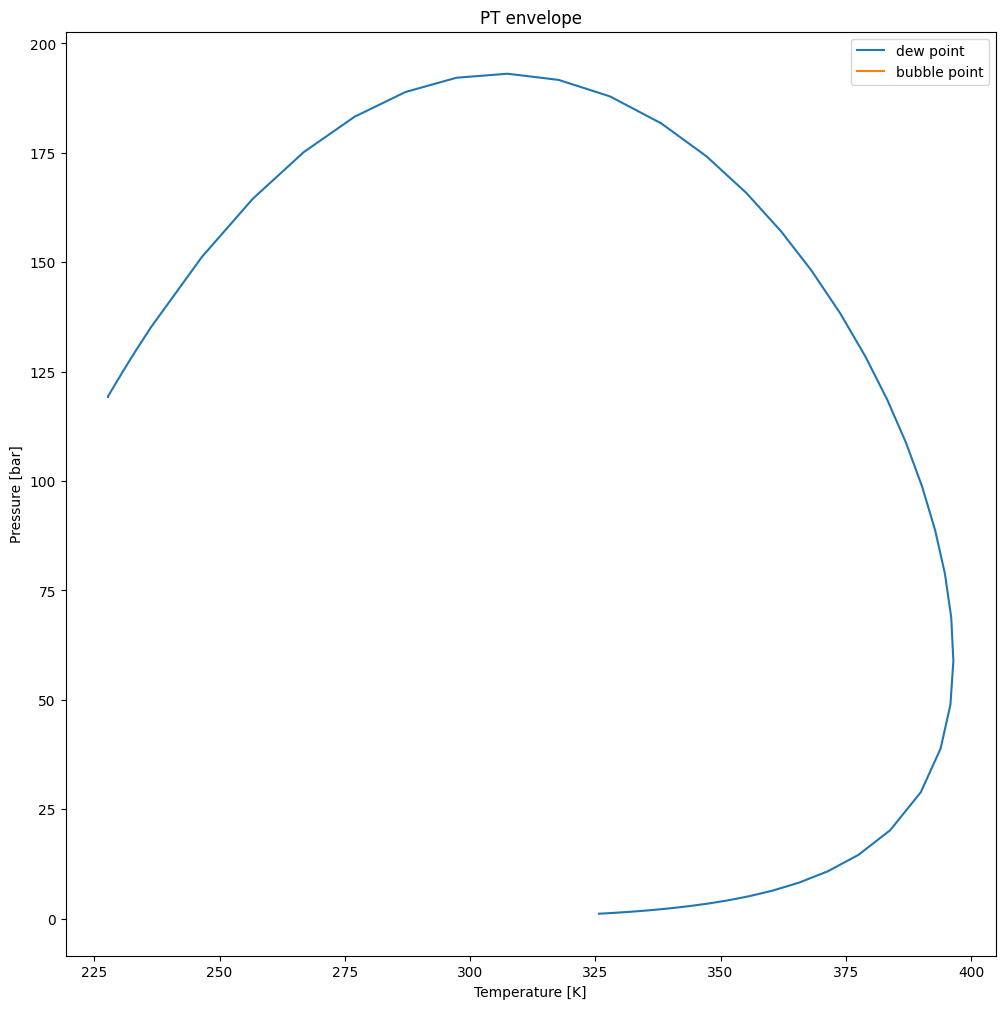

In [49]:
from neqsim.thermo import phaseenvelope
envelope = phaseenvelope(reservoirFluid)
plt.plot(list(envelope.getOperation().get("dewT2")),list(envelope.getOperation().get("dewP2")), label="dew point")
plt.plot(list(envelope.getOperation().get("bubT")),list(envelope.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()

## Rich gas

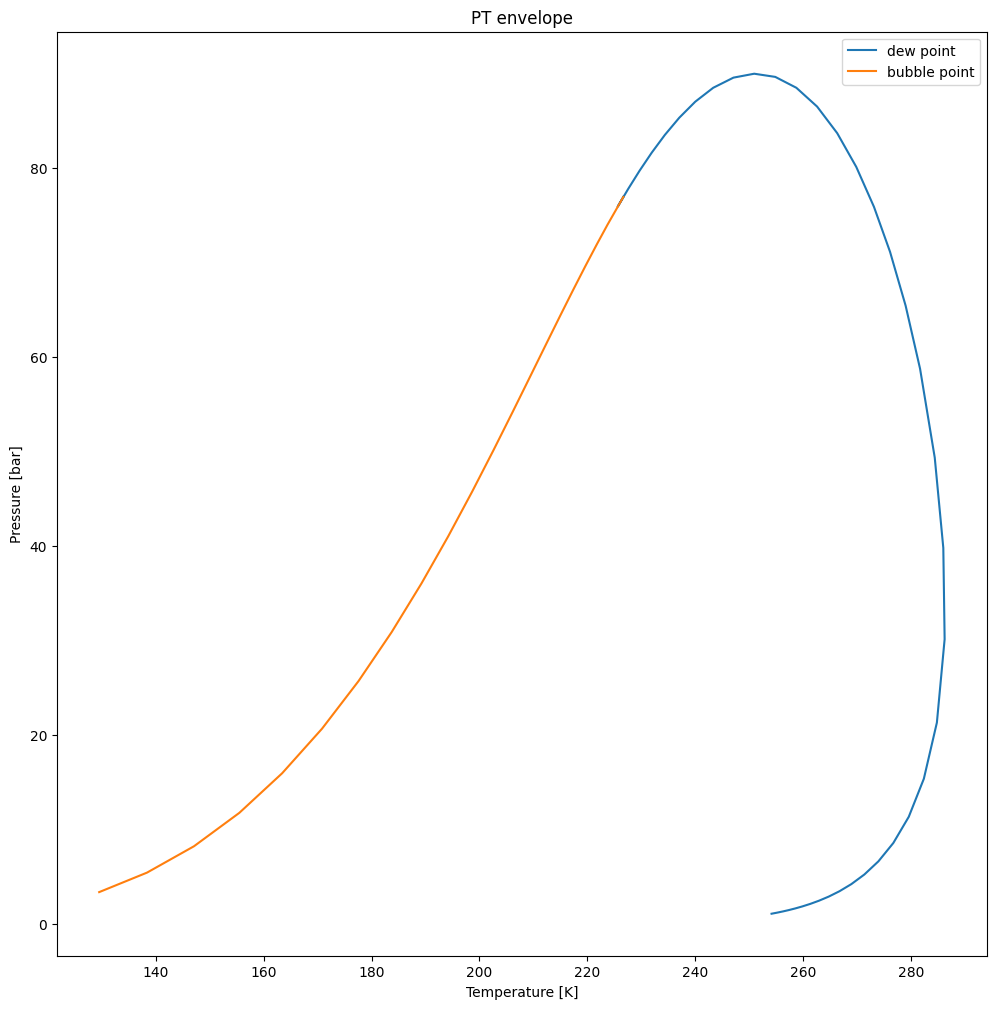

None


In [50]:
if dewPointScrubber.getGasOutStream().getFluid().hasComponent('water'):
  dewPointScrubber.getGasOutStream().getFluid().removeComponent("water")
envelope2 = phaseenvelope(dewPointScrubber.getGasOutStream().getFluid())
plt.plot(list(envelope2.getOperation().get("dewT")),list(envelope2.getOperation().get("dewP")), label="dew point")
plt.plot(list(envelope2.getOperation().get("bubT")),list(envelope2.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()
print(envelope2.getOperation().get("CCB"))

## Dry gas

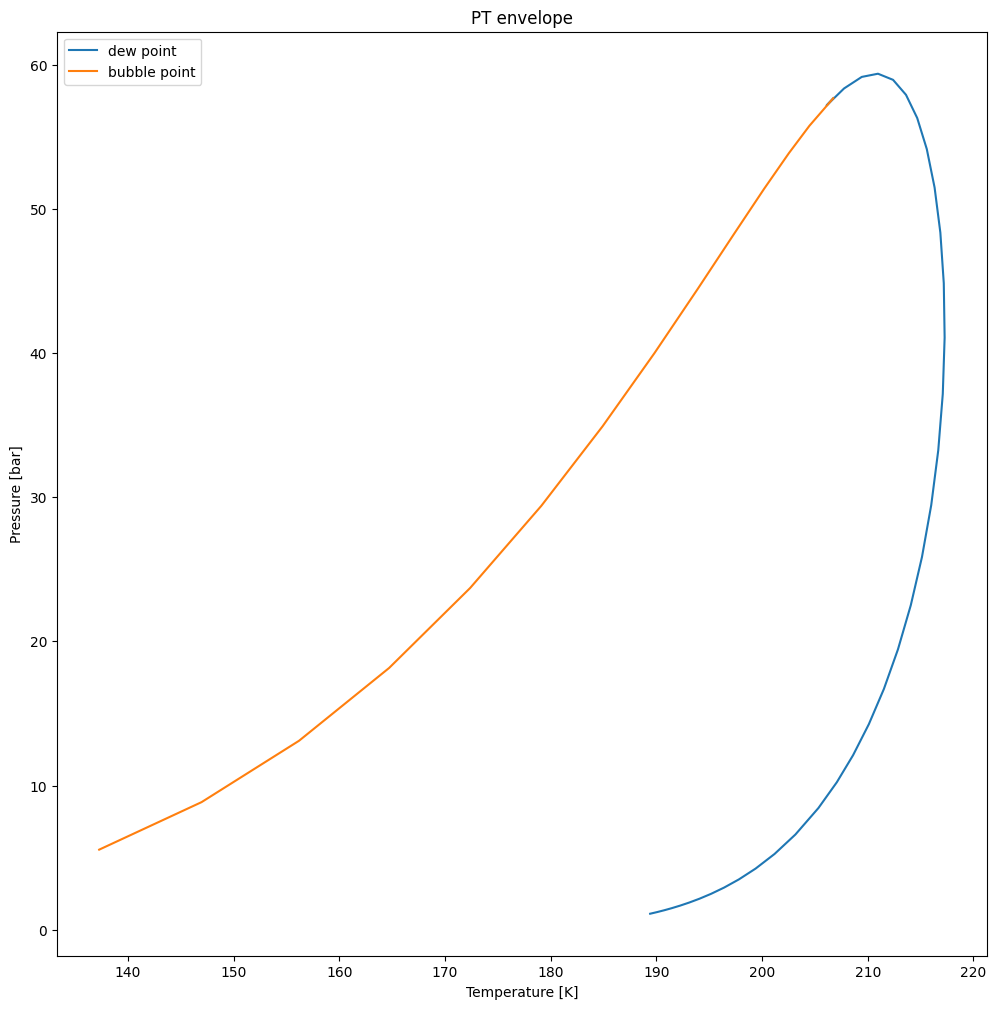

In [51]:
exportDryGas.getFluid().removeComponent("water")
envelope3 = phaseenvelope(exportDryGas.getFluid())
plt.plot(list(envelope3.getOperation().get("dewT")),list(envelope3.getOperation().get("dewP")), label="dew point")
plt.plot(list(envelope3.getOperation().get("bubT")),list(envelope3.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()

# Some final calculations

Total power from both offshore and onshore compressors

In [52]:
totalPowerOffshoreOnshore = totalPowerOnshore + totalCompressorPowerOffshore
print('total compressor power onhsore and ofshore ',totalPowerOffshoreOnshore/1e3, ' MW')

total compressor power onhsore and ofshore  168.54913203504134  MW


In a real offshore process more recompressor stages would be needed. The compressor pressure stages can be calculated from:

In [53]:
import math
lowP = 1.3
highP = 78.0
numerOfCompressorStages = 4

pres = [lowP]
for stage in range(1,numerOfCompressorStages):
  temp = math.pow(lowP,numerOfCompressorStages-stage)*math.pow(highP, stage)
  pres.append(math.pow(temp, (1.0/numerOfCompressorStages)))

pres.append(highP)
print(pres)

[1.3, 3.618104988827863, 10.069756700139283, 28.02572073312057, 78.0]


Calculation of sales gas quality papreters from onshore process:

In [54]:
from neqsim.standards import ISO6976

dryGasExportRate = exportDryGas.getFlowRate('kg/sec')
dryGasExportRateperday = exportDryGas.getFlowRate('MSm3/day')

referenceTemperatureVolume = "15.0"
referenceTemperatureCombustion = 15.0
numberUnit = 'mass'

iso6976 = ISO6976(exportDryGas.getFluid())
iso6976.setReferenceType(numberUnit)
iso6976.setVolRefT(float(referenceTemperatureVolume))
iso6976.setEnergyRefT(float(referenceTemperatureCombustion))
iso6976.calculate()

GCV = round(iso6976.getValue("SuperiorCalorificValue")/1.0e3,3)
WI = round(iso6976.getValue("SuperiorWobbeIndex")/1.0e3,3)
WIkwh = round(iso6976.getValue("SuperiorWobbeIndex")/1.0e3/3.6,3)
relDens = round(iso6976.getValue("RelativeDensity"),3)

print('GCV '+ str(GCV) + ' MJ/' +numberUnit)
print('WI '+ str(WI), ' MJ/' +numberUnit)
print('WI '+ str(WIkwh), ' kWh/' +numberUnit)
print('Relative density '+ str(relDens), ' [-]')


numberUnit = 'volume'

iso6976 = ISO6976(exportDryGas.getFluid())
iso6976.setReferenceType(numberUnit)
iso6976.setVolRefT(float(referenceTemperatureVolume))
iso6976.setEnergyRefT(float(referenceTemperatureCombustion))
iso6976.calculate()

LCV = round(iso6976.getValue("InferiorCalorificValue")/1.0e3,3)

print('LCV '+ str(LCV) + ' MJ/' +numberUnit)

print('dry gas production ', dryGasExportRateperday, ' MSm^3/day')
print('dry gas production ', dryGasExportRate, ' kg/sec')
print('power to europe as dry gas ', dryGasExportRate*GCV, ' MW')
print('annual energy of produced dry gas ', dryGasExportRate*GCV*24*365/1e6 , ' TWh per year')

GCV 52.006 MJ/mass
WI 66.542  MJ/mass
WI 18.484  kWh/mass
Relative density 0.611  [-]
LCV 35.12 MJ/volume
dry gas production  43.555102944918524  MSm^3/day
dry gas production  376.49043060157226  kg/sec
power to europe as dry gas  19579.76133386537  MW
annual energy of produced dry gas  171.51870928466064  TWh per year


Compare to electricity produced in Norway

https://energifaktanorge.no/en/norsk-energiforsyning/kraftproduksjon/

We see that the energy produced only from the Åsgard Transport pipeline, is significantly higher than the electrical production in Norway (total of hydro, wind, thermal)

In a natural gas combined cycle power plant with an efficiency of 60 %, as another example, 0,33 kg of carbon dioxide is emitted per kWhel. How much of the sales gas will be used for production of power for delivering electricity to compressors (onshore and offshore combined)? What is the yearly amount of CO2 that needs to be captured from the flue gas from the gas fired power plant?

In [55]:
powerProductionEfficiency = 0.6
gasNeedForPower = totalPowerOffshoreOnshore/1e3/LCV/powerProductionEfficiency*3600*24/1e6  #  J/sec / J/m3
print('sales gas needed for power production ', gasNeedForPower, ' MSm3/day')
print('% of dry gas export ', gasNeedForPower/exportDryGas.getFlowRate('MSm3/day')*100)

co2emissionperkwhel = 0.33
powerkWhperyear = totalPowerOffshoreOnshore*24*365
co2emissionsperyear =  0.33*powerkWhperyear
print('CO2 emission for power production ' , co2emissionsperyear/1e6, ' thousand tons per year')

sales gas needed for power production  0.6910898352234042  MSm3/day
% of dry gas export  1.5867023345057483
CO2 emission for power production  487.24183088689756  thousand tons per year


Calculation of CO2 emission per boe produced in the chain

In [56]:
streamdaysperyear = 360
boeperm3oe = 6.2898
m3oeproducedyear = dryGasExportRateperday*1e3*streamdaysperyear + offshorecondesateproduction*streamdaysperyear + nglproduction*streamdaysperyear*1.9

print('Sales gas [MSm oe] ', dryGasExportRateperday*1e3*streamdaysperyear/1e6)
print('Condensate [MSm oe] ', offshorecondesateproduction*streamdaysperyear/1e6)
print('NGL [MSm oe] ', nglproduction*streamdaysperyear*1.9/1e6)

print('million m^3 oe produced per year ',  m3oeproducedyear/1e6)
print('boe produced per year [boe per year] ',  m3oeproducedyear*boeperm3oe)

print('kg CO2 per barrel of oil equivalent (boe) ' , co2emissionsperyear/(m3oeproducedyear*boeperm3oe))


Sales gas [MSm oe]  15.679837060170668
Condensate [MSm oe]  3.271094993138168
NGL [MSm oe]  9.112170340190277
million m^3 oe produced per year  28.063102393499115
boe produced per year [boe per year]  176511301.43463072
kg CO2 per barrel of oil equivalent (boe)  2.760400194926572


## Process flow illustration

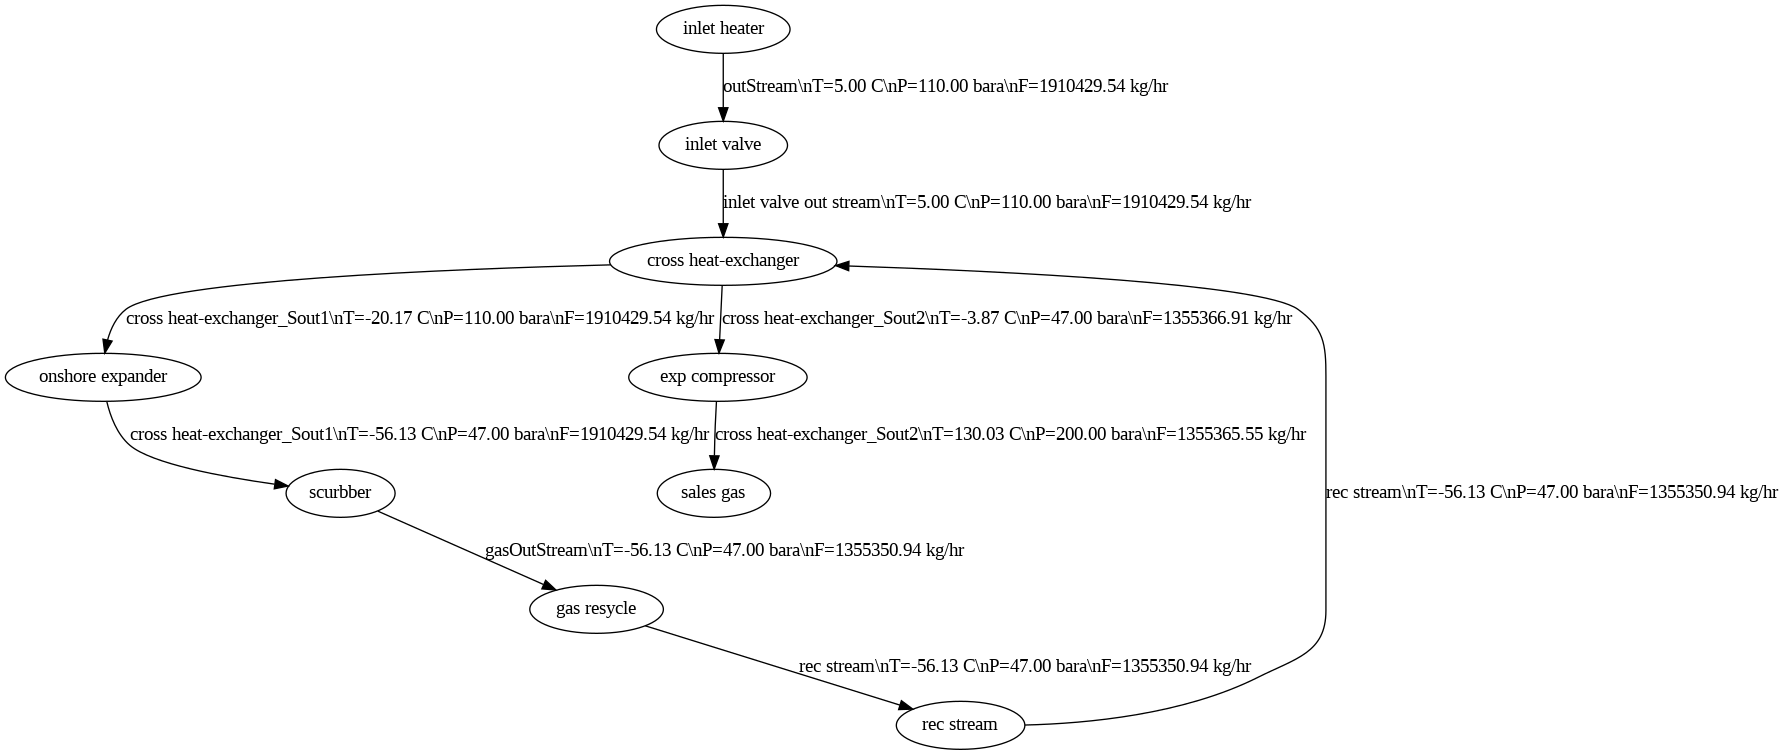

In [57]:
import graphviz
from neqsim import jneqsim as neqsim

options = neqsim.process.processmodel.ProcessSystemGraphvizExporter.GraphvizExportOptions.builder().includeStreamTemperatures(True).includeStreamPressures(True).includeStreamFlowRates(True).includeStreamPropertyTable(False).tablePlacement(
                neqsim.process.processmodel.ProcessSystemGraphvizExporter.GraphvizExportOptions.TablePlacement.BELOW).build()

getProcess().exportToGraphviz("process.dot", options)

# Read the dot file
with open('process.dot', 'r') as f:
    dot_graph = f.read()

# Render the dot file and display it
graphviz.Source(dot_graph).render("process_flow_diagram", format="png", cleanup=True)

from IPython.display import Image
Image('process_flow_diagram.png')

Reflection: What is the most effective way to reduce CO2 emissions per boe produced?